In [2]:
from datetime import timedelta
from mockseries.trend import LinearTrend
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise, GaussianNoise
from datetime import datetime
from mockseries.utils import datetime_range
from mockseries.utils import plot_timeseries, write_csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
trend = LinearTrend(coefficient=2, time_unit=timedelta(days=10), flat_base=100)
seasonality = SinusoidalSeasonality(amplitude=30, period=timedelta(days=200)) \
              + SinusoidalSeasonality(amplitude=4, period=timedelta(days=30)) \
              + SinusoidalSeasonality(amplitude=10, period=timedelta(days=2))
noise = GaussianNoise(mean=4, std=5)

timeseries = trend + seasonality + noise

In [4]:
print(356*24*2000*64)

1093632000


In [5]:
print("Mib = " + (str)(25*365*24*60*4/1.049e+6))

Mib = 50.10486177311726


In [ ]:
startYears = np.linspace(1500, 1500+25*64, 65, dtype=int)
endYears = np.linspace(1525, 1525+25*64, 65, dtype=int)

# prima di questo inserisce nel file binario la lunghezza del file finale
output_file = "complete_timeseries.bin"
index = 1


for startYear, endYear in zip(startYears, endYears):
    start = datetime(startYear, 1, 1)
    end = datetime(endYear, 12, 31)

    ts_index = datetime_range(
        granularity=timedelta(minutes=1),
        start_time=start,
        end_time=end,
    )

    # appendi nel file binario i valori
    values_numpy = np.array(timeseries.generate(ts_index), dtype=np.float32)

    with open(output_file, "ab") as f:  # "ab" mode ensures appending
        f.write(values_numpy.tobytes())

    if index in [1, 2, 4, 8, 16, 32, 64]:
        length = np.array([len(values_numpy) * index], dtype=np.float32)
        length_int = len(values_numpy) * index
        length.tofile(f"{index}Threads_{length_int}values.bin")

        with open(f"{index}Threads_{length_int}values.bin", "ab") as f_new:
            with open(output_file, "rb") as f_old:
                f_new.write(f_old.read())
    
    if index == 1:
        create_subset(1000, values_numpy, "1000_subset.bin")
    
    index += 1

In [9]:
ts_index = datetime_range(
    granularity=timedelta(minutes=1),
    start_time=datetime(1500, 1, 1),
    end_time=datetime(1700, 1, 1),
)
entire_ts_values = timeseries.generate(ts_index)

In [11]:
print("Mib = " + (str)(len(entire_ts_values)*4/1.049e+6))

Mib = 401.10795042897996


In [6]:
def create_binary_file(values, filename):
    length = np.array([len(values)], dtype=np.float32)
    values_numpy = np.array(values, dtype=np.float32)
    values_numpy = np.insert(values_numpy, 0, length)
    values_numpy.tofile(f"{filename}.bin")

In [7]:
def create_subset(range_size, values, filename):
    start_index = np.random.randint(0, len(values) - range_size)
    end_index = start_index + range_size
    create_binary_file(values[start_index:end_index], f"range-{range_size}_of-{filename}")

In [12]:
ts_values = entire_ts_values[0:int(len(entire_ts_values))]

In [ ]:
filename = f"entire_{len(ts_values)}_entries"
print(len(ts_values))
create_binary_file(ts_values, filename)
steps = [10, 100, 1000, 10000, 100000, 1000000]
for step in steps:
    create_subset(step, ts_values, filename)

17531640


In [6]:
write_csv(ts_index, ts_values, "hello_mockseries.csv")

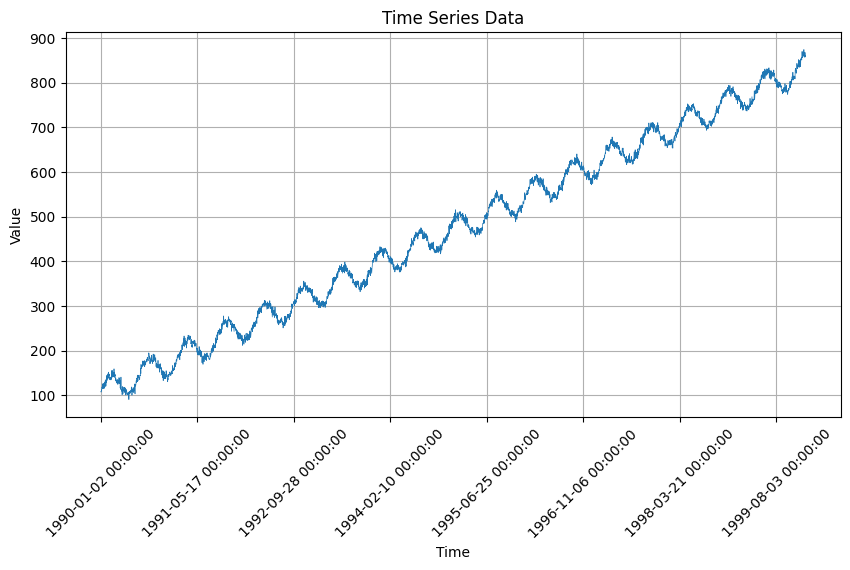

In [8]:
# Leggi il file CSV
df = pd.read_csv("hello_mockseries.csv", sep=';', decimal=".")

# Crea il grafico
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.title('Time Series Data')
plt.grid(True)

# Genera solo 10 tick sull'asse x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

# Salva il grafico come SVG
plt.savefig("hello_mockseries.svg", format='svg')
# Salva il grafico anche in formato PDF
plt.savefig("hello_mockseries.pdf", format='pdf')

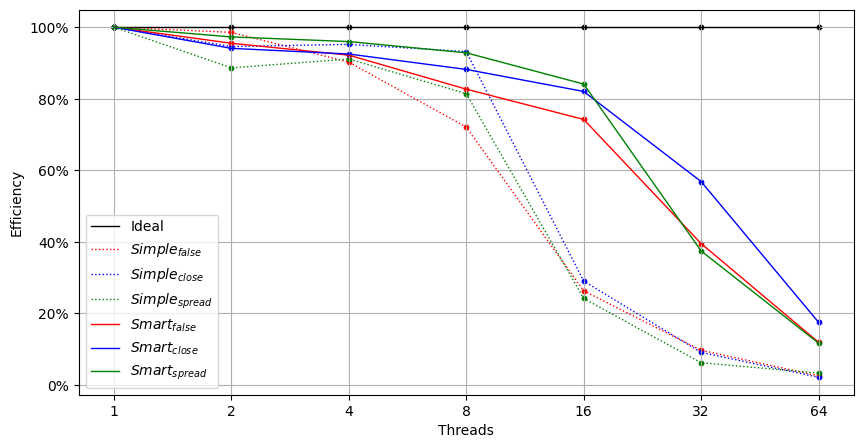

In [3]:


idealTime = [20292, 10146, 5073, 2536.5, 1268.25, 634.125, 317.0625]

staticSimple_false = [20292, 10294, 5622, 3520, 4828, 6584, 12746]
staticSimple_close = [20292,10725,5329,2722,4375,7005,15067]
staticSimple_spread = [20292,11448,5568,3116,5254,10321,9688]


smartStaticSimple_false = [20292,10623,5503,3068,1709,1606,2671]
smartStaticSimple_close = [20292,10783,5484,2876,1546,1116,1814]
smartStaticSimple_spread = [20292,10429,5285,2732,1508,1695,2725]

threads = ["1", "2", "4", "8", "16", "32", "64"]

plt.figure(figsize=(10, 5))

plt.plot(threads, np.ones(len(threads)), label="Ideal", linestyle='-', linewidth=1, color='black')
plt.scatter(threads, np.ones(len(threads)), s=10, color='black')

plt.plot(threads, np.array(idealTime) / np.array(staticSimple_false), label=r"$Simple_{false}$", linestyle=':', linewidth=1, color='red')
plt.scatter(threads, np.array(idealTime) / np.array(staticSimple_false), s=10, color='red')
plt.plot(threads, np.array(idealTime) / np.array(staticSimple_close), label=r"$Simple_{close}$", linestyle=':', linewidth=1, color='blue')
plt.scatter(threads, np.array(idealTime) / np.array(staticSimple_close), s=10, color='blue')
plt.plot(threads, np.array(idealTime) / np.array(staticSimple_spread), label=r"$Simple_{spread}$", linestyle=':', linewidth=1, color='green')
plt.scatter(threads, np.array(idealTime) / np.array(staticSimple_spread), s=10, color='green')

plt.plot(threads, np.array(idealTime) / np.array(smartStaticSimple_false), label=r"$Smart_{false}$", linestyle='-', linewidth=1, color='red')
plt.scatter(threads, np.array(idealTime) / np.array(smartStaticSimple_false), s=10, color='red')
plt.plot(threads, np.array(idealTime) / np.array(smartStaticSimple_close), label=r"$Smart_{close}$", linestyle='-', linewidth=1, color='blue')
plt.scatter(threads, np.array(idealTime) / np.array(smartStaticSimple_close), s=10, color='blue')
plt.plot(threads, np.array(idealTime) / np.array(smartStaticSimple_spread), label=r"$Smart_{spread}$", linestyle='-', linewidth=1, color='green')
plt.scatter(threads, np.array(idealTime) / np.array(smartStaticSimple_spread), s=10, color='green')

plt.xticks(threads)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

plt.xlabel('Threads')
plt.ylabel('Efficiency')
plt.grid(True)
plt.legend()

plt.savefig("smartVsSimple.pdf", format='pdf')

